<a href="https://colab.research.google.com/github/Satwikram/Human-Activity-Recognition/blob/main/Human%20Activity%20Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading and Unzipping the Dataset

In [2]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2021-05-23 09:05:20--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  60.6MB/s    in 46s     

2021-05-23 09:06:06 (66.8 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [ ]:
!pip install pafy
!pip install pafy youtube-dl moviepy

In [1]:
import os

import cv2

import math

import pafy

import random

import numpy as np

import datetime as dt

import tensorflow as tf

from moviepy.editor import *
from collections import deque

import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


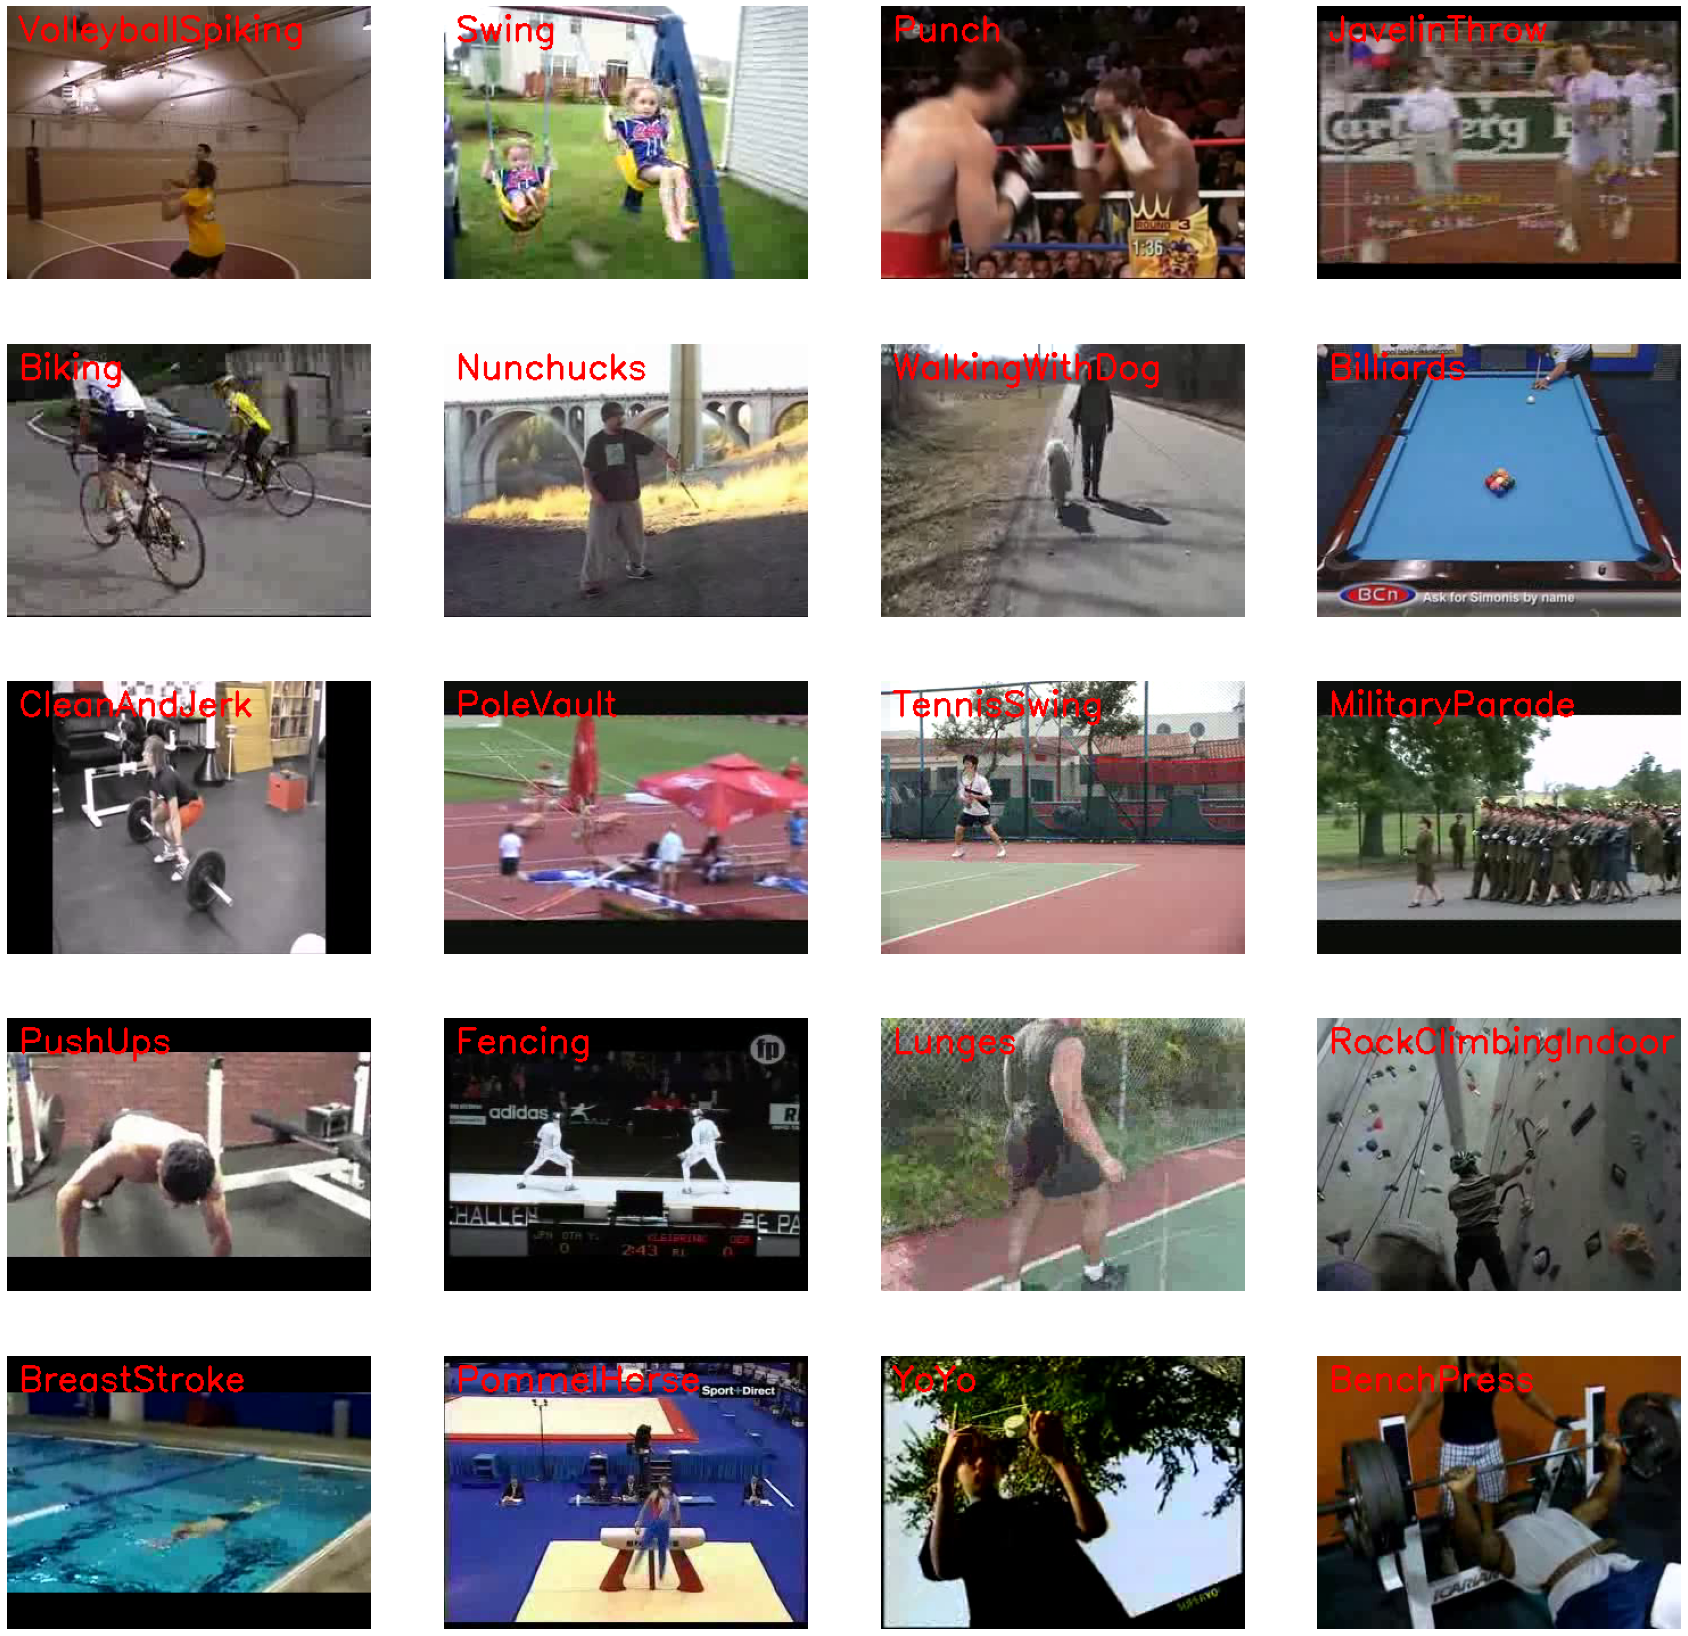

In [2]:
plt.figure(figsize = (30, 30))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):

    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

    # Reading The First Frame of the Video File
    _, bgr_frame = video_reader.read()

 
    # Closing the VideoCapture object and releasing all resources.
    video_reader.release()
    # Converting the BGR Frame to RGB Frame
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Adding The Class Name Text on top of the Video Frame.

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

     

    # Assigning the Frame to a specific position of a subplot

    plt.subplot(5, 4, counter)

    plt.imshow(rgb_frame)

    plt.axis('off')

In [2]:
image_height, image_width = 64, 64

max_images_per_class = 2000

dataset_directory = "UCF50"

classes_list = ['JumpingJack','PlayingViolin','Basketball','HulaHoop','YoYo','TrampolineJumping','VolleyballSpiking','Mixing','PizzaTossing',
                'PlayingPiano','Drumming','Lunges','TennisSwing','Nunchucks','SalsaSpin','PullUps','Punch','ThrowDiscus','PlayingTabla','Rowing']

model_output_size = len(classes_list)

In [4]:
def frames_extraction(video_path):

    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    while True:

        success, frame = video_reader.read()

        if not success:

            break

        resized_frame = cv2.resize(frame, (image_height, image_width))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

In [5]:
def create_dataset():

    temp_features = []

    features = []

    labels = []

    for class_index, class_name in enumerate(classes_list):

        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        for file_name in files_list:

            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            frames = frames_extraction(video_file_path)

            temp_features.extend(frames)

        features.extend(random.sample(temp_features, max_images_per_class))

        labels.extend([class_index] * max_images_per_class)

        temp_features.clear()

    features = np.asarray(features)

    labels = np.array(labels) 

    return features, labels


In [6]:
features, labels = create_dataset()

Extracting Data of Class: JumpingJack
Extracting Data of Class: PlayingViolin
Extracting Data of Class: Basketball
Extracting Data of Class: HulaHoop
Extracting Data of Class: YoYo
Extracting Data of Class: TrampolineJumping
Extracting Data of Class: VolleyballSpiking
Extracting Data of Class: Mixing
Extracting Data of Class: PizzaTossing
Extracting Data of Class: PlayingPiano
Extracting Data of Class: Drumming
Extracting Data of Class: Lunges
Extracting Data of Class: TennisSwing
Extracting Data of Class: Nunchucks
Extracting Data of Class: SalsaSpin
Extracting Data of Class: PullUps
Extracting Data of Class: Punch
Extracting Data of Class: ThrowDiscus
Extracting Data of Class: PlayingTabla
Extracting Data of Class: Rowing


In [4]:
import joblib

In [8]:
joblib.dump(features, '/content/drive/MyDrive/HAR/features.pickle')

['/content/drive/MyDrive/HAR/features.pickle']

In [9]:
joblib.dump(labels, '/content/drive/MyDrive/HAR/labels.pickle')

['/content/drive/MyDrive/HAR/labels.pickle']

In [5]:
features = joblib.load('/content/drive/MyDrive/HAR/features.pickle')

In [6]:
labels = joblib.load('/content/drive/MyDrive/HAR/labels.pickle')

In [7]:
one_hot_encoded_labels = to_categorical(labels)

In [8]:
seed_constant = 23

np.random.seed(seed_constant)

random.seed(seed_constant)

tf.random.set_seed(seed_constant)


In [9]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [10]:
def create_model():


    model = Sequential()

 

    # Defining The Model Architecture

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (64, 64, 3)))

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))

    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation = 'relu'))
    model.add(BatchNormalization())

    model.add(Dense(model_output_size, activation = 'softmax'))

    model.summary()

    return model

model = create_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 64)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1

In [ ]:
#load_model = tf.keras.models.load_model('/content/drive/MyDrive/HAR/har.h5')

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True, verbose = 1)

checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/HAR/har.h5', monitor = 'val_loss', verbose = 1, save_best_only = True,
                                                mode = 'min')

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

model_training_history = model.fit(x = features_train, y = labels_train, epochs = 20, batch_size = 32 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback, checkpoint])

Epoch 1/20
800/800 [==============================] - 748s 934ms/step - loss: 2.0318 - accuracy: 0.3768 - val_loss: 1.5902 - val_accuracy: 0.5134

Epoch 00001: val_loss improved from inf to 1.59016, saving model to /content/drive/MyDrive/HAR/har.h5
Epoch 2/20
800/800 [==============================] - 732s 915ms/step - loss: 0.7967 - accuracy: 0.7700 - val_loss: 1.0919 - val_accuracy: 0.6702

Epoch 00002: val_loss improved from 1.59016 to 1.09190, saving model to /content/drive/MyDrive/HAR/har.h5
Epoch 3/20
800/800 [==============================] - 721s 901ms/step - loss: 0.4117 - accuracy: 0.8857 - val_loss: 0.7324 - val_accuracy: 0.7775

Epoch 00003: val_loss improved from 1.09190 to 0.73237, saving model to /content/drive/MyDrive/HAR/har.h5
Epoch 4/20
800/800 [==============================] - 670s 838ms/step - loss: 0.2384 - accuracy: 0.9350 - val_loss: 0.8876 - val_accuracy: 0.7336

Epoch 00004: val_loss did not improve from 0.73237
Epoch 5/20
800/800 [===========================

In [24]:
len(features)

32000

In [25]:
import joblib

In [26]:
joblib.dump(features, 'features.pickle')

['features.pickle']

In [27]:
a = joblib.load('/content/features.pickle')

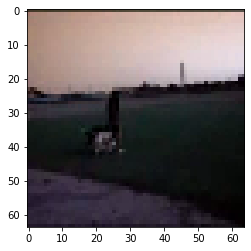

In [28]:
plt.imshow(a[0])

In [29]:
type(a)

numpy.ndarray

In [30]:
with open('featres.npy', 'wb') as f:
    np.save(f, features)

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
b = np.load('/content/featres.npy')

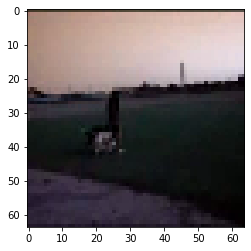

In [5]:
plt.imshow(b[0])